# 1. SETTINGS

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# garbage collection
import gc
gc.enable()

In [3]:
# pandas options
pd.set_option("display.max_columns", None)

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# random settings
seed = 42

# 2. PREPARATIONS

In [6]:
# dataset
data = "v1"

In [7]:
# import data
train = pd.read_csv("train_full_cor.csv")
test  = pd.read_csv("test_full_cor.csv")
y     = pd.read_csv("y_full_cor.csv")

In [8]:
# sort data
train = train.sort_values("SK_ID_CURR")
y     = y.sort_values("SK_ID_CURR")

In [9]:
# extract target
y = y["TARGET"]

In [10]:
# exclude features
excluded_feats = ["SK_ID_CURR"]
features = [f for f in train.columns if f not in excluded_feats]

In [11]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 1824)
(48744, 1824)


In [12]:
### PARAMETERS

# parallel settings
cores = 10

# learner settings
metric   = "auc"
verbose  = 500
stopping = 300

# CV settings
num_folds = 5
shuffle   = True

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)

# 3. CROSS-VALIDATION

## 3.1. ALL FEATURES

In [13]:
# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

# placeholders
valid_aucs_cv = np.zeros(num_folds) 
test_preds_cv = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()

In [17]:
# Your column cleaning logic (this part is fine)
train.columns = ["".join (c if c.isalnum() else '_' for c in str(x)) for x in train.columns]
test.columns = ["".join (c if c.isalnum() else '_' for c in str(x)) for x in test.columns]

# THE FIX: Instead of trying to index the DataFrame with old names,
# simply apply the same cleaning logic to the 'features' list itself.
features = ["".join (c if c.isalnum() else '_' for c in str(x)) for x in features]

# Now, the names in your 'features' list will perfectly match 
# the new column names in your 'train' DataFrame. ✅

In [18]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # train lightGBM
    gbm.fit(trn_x, trn_y, 
            eval_set=[(trn_x, trn_y), (val_x, val_y)], 
            eval_metric=metric, 
            callbacks=[
                lgb.log_evaluation(period=verbose), 
                lgb.early_stopping(stopping_rounds=stopping)
            ])
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration_
    
    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits 
    
    # importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["Importance"] = gbm.feature_importances_
    fold_importance_df["Fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")
    
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# print overall performance    
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % np.mean(valid_aucs_cv))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.019614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187248
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 1724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 300 rounds
[500]	training's auc: 0.811743	training's binary_logloss: 0.231976	valid_1's auc: 0.768186	valid_1's binary_logloss: 0.244144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

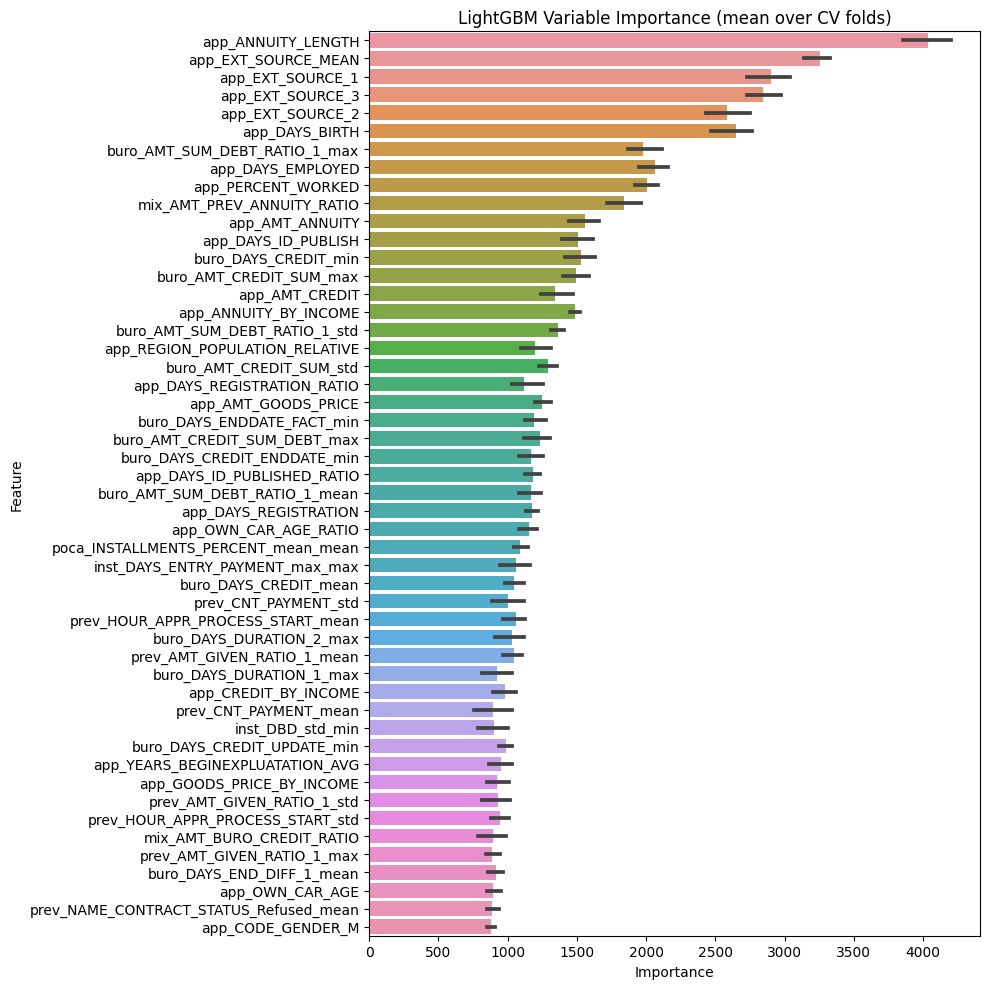

In [20]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 50
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top_feats].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "Importance", y = "Feature", data = importance.sort_values(by = "Importance", ascending = False))
plt.title('LightGBM Variable Importance (mean over CV folds)')
plt.tight_layout()

# save plot as pdf
plt.savefig("var_importance.pdf")

## 3.2. TOP FEATURES

In [21]:
# keep top features
top = 500
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
features = list(importance.groupby("Feature").Importance.mean().sort_values(ascending = False).index)

In [22]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 500)
(48744, 500)


In [24]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y, 
            eval_set=[(trn_x, trn_y), (val_x, val_y)], 
            eval_metric=metric, 
            callbacks=[
                lgb.log_evaluation(period=verbose), 
                lgb.early_stopping(stopping_rounds=stopping)])
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration_
    
    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits
    
    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")

    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# print overall performance    
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % auc)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.554567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103452
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 300 rounds


KeyboardInterrupt: 

In [25]:
# Import necessary libraries
import gc
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# --- Assume the following variables are already defined ---
# train: your training DataFrame
# test: your testing DataFrame
# y: your target series
# features: list of feature names to use
# folds: your CV splitter object (e.g., StratifiedKFold)
# gbm: your initialized lgb.LGBMClassifier()
# metric, verbose, stopping: your learner settings

# --- Main Code Block ---

# 1. Initialize a list to store the models from each fold
models = []

# Initialize arrays for predictions and scores
test_preds_cv = np.zeros(len(test))
valid_aucs_cv = np.zeros(folds.get_n_splits())
feature_importance_df = pd.DataFrame()


### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # Data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # Train lightGBM
    gbm.fit(trn_x, trn_y, 
            eval_set=[(trn_x, trn_y), (val_x, val_y)], 
            eval_metric=metric, 
            callbacks=[
                lgb.log_evaluation(period=verbose), 
                lgb.early_stopping(stopping_rounds=stopping)
            ])
    
    # 2. Save the trained model from this fold into your list
    models.append(gbm)
    
    # Save number of iterations
    num_iter_cv = gbm.best_iteration_
    
    # Predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration=num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration=num_iter_cv)[:, 1] / folds.n_splits
    
    # Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["Importance"] = gbm.feature_importances_
    fold_importance_df["Fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # Print performance
    print("----------------------")
    print("Fold %2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")

    # Clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# Print overall performance    
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % auc)
print(f"\nSuccessfully trained and saved {len(models)} models.")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.406293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103452
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 300 rounds
[500]	training's auc: 0.811346	training's binary_logloss: 0.232198	valid_1's auc: 0.768652	valid_1's binary_logloss: 0.244022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [26]:
print(models)

[LGBMClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=7,
               min_child_weight=2, min_split_gain=0.01, n_estimators=10000,
               num_leaves=70, num_threads=10, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.9), LGBMClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=7,
               min_child_weight=2, min_split_gain=0.01, n_estimators=10000,
               num_leaves=70, num_threads=10, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.9), LGBMClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=7,
               min_child_weight=2, min_split_gain=0.01, n_estimators=10000,
               num_leaves=70, num_threads=10, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.9), LGBMClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=7,
               min_child_weight=2, min_split_gain=0.01, n_estimators=10000,
               num_leaves=70, num_th

In [27]:
pip install shap

  Using cached numba-0.61.2-cp311-cp311-win_amd64.whl.metadata (2.9 kB)
  Using cached llvmlite-0.44.0-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ---------------------------------------- 544.4/544.4 kB 2.6 MB/s  0:00:00
Using cached numba-0.61.2-cp311-cp311-win_amd64.whl (2.8 MB)
Using cached llvmlite-0.44.0-cp311-cp311-win_amd64.whl (30.3 MB)

   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   ------------------------ -------

In [34]:
import shap
import matplotlib.pyplot as plt

# Select the model to explain
model_to_explain = models[0]

# Get the corresponding validation data
first_fold_trn_idx, first_fold_val_idx = next(iter(folds.split(train, y)))
validation_data = train[features].iloc[first_fold_val_idx]

# Create the sample
validation_sample = validation_data.sample(n=2000, random_state=42)

# Create the SHAP explainer using the .booster_ attribute
explainer = shap.TreeExplainer(model_to_explain.booster_)

# Calculate SHAP values
shap_values = explainer.shap_values(validation_sample) # No .values needed with this method

# Verify the shape. It should now be (2000, 500).
print(f"Shape of SHAP values matrix for the positive class: {shap_values[1].shape}")

# Generate the plot
print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values[1], validation_sample)

Shape of SHAP values matrix for the positive class: (500,)
Generating SHAP Summary Plot...


AssertionError: Summary plots need a matrix of shap_values, not a vector.

# 4. SUBMISSION

In [ ]:
# create submission
test["TARGET"] = test_preds_cv
subm = test[["SK_ID_CURR", "TARGET"]]

In [ ]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
best = pd.read_csv("../submissions/rmean_top7_03072018.csv")
spearmanr(test.TARGET, best.TARGET)

In [ ]:
# export CSV
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_bag_lgb_top" + str(top) + ".csv", index = False, float_format = "%.8f")

In [ ]:
# no card, old features (560):            0.786941 | 0.783
# no card, new features (694):            0.788893 | 0.783
# with card, new features (1072):         0.790123 | 0.787
# with card and kernel features (1109):   0.790053 | 
# card, kernel, factorize, no na (978):   0.790803 | 
# card, kern, fac, nona, adummy (1193):   0.791321 |
# full data, one-hot ecoding (1844):      0.791850 |
# full data, one-hot, extra sums (2486):  0.791880 | 0.789 
# full, one-hot, sums, buroscore (2501):  0.791761 | 
# full, one-hot, clean, buroscore (1826): 0.791867 |
# last data + ext, age ratios (1828):     0.791808 |
# new app feats, remove weighted (1830):  0.794241 | 0.795
# previous data - top1000 LGB features:   0.794384 |
# select top1500 LGB features:            0.794384 |